# Data Extractor and Plotter

This jupyter notebook extracts data from .txt files stored in the "Data" directory. It compiles the data into usable statistics, and plots average runtime, success rate, and sum-of-costs ratio. 

Plots are automatically generated and stored in a "Figures" directory. All directories are automatically created if they do not already exist. Within the "Figures" directory, grouped map plots and individual map plots are separated.

## Dependencies and Initializations

In [25]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from collections import defaultdict
from matplotlib.ticker import FuncFormatter
import pandas as pd
import numpy as np
import os
import csv

In [27]:
algorithms = ["CBS", "PBS"]
resolutions = [1, 2, 4]

# maps and map groupings
map_groupings = {"empty": ["empty-8-8", "empty-16-16", "empty-32-32", "empty-48-48"],
                 "random": ["random-32-32-10", "random-32-32-20", "random-64-64-10", "random-64-64-20"],
                 "narrow":  ["room-32-32-4", "room-64-64-8", "room-64-64-16", "maze-32-32-2", "maze-32-32-4", "maze-128-128-2", "maze-128-128-10"], 
                 "cities": ["Berlin_1_256", "Boston_0_256", "Paris_1_256"],
                 "games": ["ht_chantry", "ht_mansion_n", "lak303d", "lt_gallowstemplar_n", "den312d", "ost003d", "brc202d", "den520d", "w_woundedcoast"]}               
map_names = [map_name for map_group in map_groupings.values() for map_name in map_group]
group_mapper = {value: key for key, values in map_groupings.items() for value in values}


# plotting colors and specifications
cbs_color = ['#ffb3a7', '#eb6574', '#93003a'] # warm colors (light to dark)
pbs_color = ['#9dced6', '#6694c1', '#00429d'] # cool colors (light to dark)

cbs_label = ['CBS, Res1', 'CBS, Res2', 'CBS, Res4']
pbs_label = ['CBSw/P, Res1', 'CBSw/P, Res2', 'CBSw/P, Res4']

# base data path
data_path = os.path.join(os.getcwd(), "Data")

A "Figures" directory to save figures is created if it does not exist. This directory will separate group figures from individual map figures. 

In [28]:
fig_dir = os.path.join(os.getcwd(), "Figures")
group_dir = os.path.join(fig_dir, "GroupedFigures")
ind_dir = os.path.join(fig_dir, "IndividualFigures")

if not os.path.isdir(fig_dir): 
    os.mkdir(fig_dir)
    print("Making a new directory to hold all figures.")
    
if not os.path.isdir(group_dir): 
    os.mkdir(group_dir)
    print("Making a new directory to hold all grouped figures.")
    
if not os.path.isdir(ind_dir): 
    os.mkdir(ind_dir)
    print("Making a new directory to hold all individual figures.")

Making a new directory to hold all figures.
Making a new directory to hold all grouped figures.
Making a new directory to hold all individual figures.


## Data Extraction

This populates individual and group statistics maps with averaged runtime, costs, and success rates. 

In [29]:
individual_stats = dict()

for map_name in map_names: 
    individual_stats[map_name] = dict()
    individual_stats[map_name]["CBS all_costs"] = {1:dict(), 2:dict(), 4:dict()} # key: (number of agents, scenario), value: cost
    individual_stats[map_name]["PBS all_costs"] = {1:dict(), 2:dict(), 4:dict()} # key: (number of agents, scenario), value: cost
    individual_stats[map_name]["CBS all_time"] = {1:defaultdict(list), 2:defaultdict(list), 4:defaultdict(list)}
    individual_stats[map_name]["PBS all_time"] = {1:defaultdict(list), 2:defaultdict(list), 4:defaultdict(list)}
    individual_stats[map_name]["CBS solved"] = {1:defaultdict(int), 2:defaultdict(int), 4:defaultdict(int)} 
    individual_stats[map_name]["PBS solved"] = {1:defaultdict(int), 2:defaultdict(int), 4:defaultdict(int)} 

    individual_stats[map_name]["CBS avg_time"] = {1:defaultdict(float), 2:defaultdict(float), 4:defaultdict(float)}
    individual_stats[map_name]["PBS avg_time"] = {1:defaultdict(float), 2:defaultdict(float), 4:defaultdict(float)}
    individual_stats[map_name]["cost ratio"] = {1:[], 2:[], 4:[]} # a list holding (number of agents, cost ratio) 
    individual_stats[map_name]["CBS success"] = {1:defaultdict(float), 2:defaultdict(float), 4:defaultdict(float)}
    individual_stats[map_name]["PBS success"] = {1:defaultdict(float), 2:defaultdict(float), 4:defaultdict(float)}
    individual_stats[map_name]["CBS min solved"] = {1:0, 2:0, 4:0}
    individual_stats[map_name]["CBS max solved"] = {1:0, 2:0, 4:0}
    individual_stats[map_name]["PBS min solved"] = {1:0, 2:0, 4:0}
    individual_stats[map_name]["PBS max solved"] = {1:0, 2:0, 4:0}

group_stats = dict()
for map_group in map_groupings: 
    group_stats[map_group] = dict()
    group_stats[map_group]["CBS all_time"] = {1:defaultdict(list), 2:defaultdict(list), 4:defaultdict(list)}
    group_stats[map_group]["PBS all_time"] = {1:defaultdict(list), 2:defaultdict(list), 4:defaultdict(list)}
    group_stats[map_group]["CBS solved"] = {1:defaultdict(int), 2:defaultdict(int), 4:defaultdict(int)} 
    group_stats[map_group]["PBS solved"] = {1:defaultdict(int), 2:defaultdict(int), 4:defaultdict(int)} 

    group_stats[map_group]["CBS avg_time"] = {1:defaultdict(float), 2:defaultdict(float), 4:defaultdict(float)}
    group_stats[map_group]["PBS avg_time"] = {1:defaultdict(float), 2:defaultdict(float), 4:defaultdict(float)}
    group_stats[map_group]["cost ratio"] = {1:[], 2:[], 4:[]} # a list holding (number of agents, cost ratio) 
    group_stats[map_group]["CBS success"] = {1:defaultdict(float), 2:defaultdict(float), 4:defaultdict(float)}
    group_stats[map_group]["PBS success"] = {1:defaultdict(float), 2:defaultdict(float), 4:defaultdict(float)}

In [30]:
def extract_lines(file_path, map_name):
    matching_lines = []
    
    # Open the file and read each line
    with open(file_path, 'r') as file:
        # Skip the header line
        header = file.readline()
        
        # Loop through the rest of the file
        for line in file:
            # Split the line by commas to access the first column
            columns = line.strip().split(',')
            
            # Check if the first column matches the given map map_name
            if columns[0] == map_name:
                matching_lines.append(line.strip())
    
    return matching_lines

In [31]:
def populate_dictionary(map_group, map_name):  
    file_path = os.path.join(data_path, map_group + ".txt")
    lines = extract_lines(file_path, map_name)

    res1_data = []
    res2_data = []
    res4_data = []
    for line in lines: 
        _, res, scenario, algorithm, num_agents, time, cost, _, _  = line.strip().split(',')
        scenario, num_agents = int(scenario), int(num_agents)
        time, cost = float(time), float(cost)
        if time > 900: 
            continue
        if res == "1": 
            res1_data.append([scenario, algorithm, num_agents, time, cost])
        elif res == "2": 
            res2_data.append([scenario, algorithm, num_agents, time, cost])
        elif res == "4": 
            res4_data.append([scenario, algorithm, num_agents, time, cost]) 

    res1_data.sort(key=lambda x: x[2])
    res2_data.sort(key=lambda x: x[2])
    res4_data.sort(key=lambda x: x[2])

    all_data = [(1, res1_data), (2, res2_data), (4, res4_data)]

    for resolution, data_lines in all_data: 
        for line in data_lines: 
            scenario, algorithm, num_agents, time, cost = line

            if algorithm == "CBS": 
                individual_stats[map_name]["CBS all_costs"][resolution][(num_agents, scenario)] = cost
                individual_stats[map_name]["CBS all_time"][resolution][num_agents].append(time)
                individual_stats[map_name]["CBS solved"][resolution][num_agents] += 1
                group_stats[map_group]["CBS all_time"][resolution][num_agents].append(time)
                group_stats[map_group]["CBS solved"][resolution][num_agents] += 1
            else: 
                individual_stats[map_name]["PBS all_costs"][resolution][(num_agents, scenario)] = cost
                individual_stats[map_name]["PBS all_time"][resolution][num_agents].append(time)
                individual_stats[map_name]["PBS solved"][resolution][num_agents] += 1
                group_stats[map_group]["PBS all_time"][resolution][num_agents].append(time)
                group_stats[map_group]["PBS solved"][resolution][num_agents] += 1


In [32]:
def populate_averages(map_name): 
    for res in resolutions: 
        for algo in algorithms: 
            # saving average times
            for num_agents, times in individual_stats[map_name][algo + " all_time"][res].items(): 
                if len(times) == 0: 
                    continue
                average_time = sum(times) / len(times)
                individual_stats[map_name][algo + " avg_time"][res][num_agents] = average_time
        
            # saving success rates
            min_solved = 0
            max_solved = 0
            for num_agents, num_solved in individual_stats[map_name][algo + " solved"][res].items(): 
                if num_solved == 25: 
                    min_solved = max(min_solved, num_agents)
                max_solved = max(num_agents, max_solved)
                
                individual_stats[map_name][algo + " success"][res][num_agents] = float(num_solved) / 25.0
            individual_stats[map_name][algo + " min solved"][res] = min_solved
            individual_stats[map_name][algo + " max solved"][res] = max_solved
        
        # saving cost ratios 
        cbs_solved = set(individual_stats[map_name]["CBS all_costs"][res].keys())
        pbs_solved = set(individual_stats[map_name]["PBS all_costs"][res].keys())
        jointly_solved = cbs_solved.intersection(pbs_solved)

        for dict_key in jointly_solved: 
            opt_cost = individual_stats[map_name]["CBS all_costs"][res][dict_key]
            sub_cost = individual_stats[map_name]["PBS all_costs"][res][dict_key]
            ratio = float(sub_cost) / float(opt_cost)

            individual_stats[map_name]["cost ratio"][res].append((dict_key[0], ratio))
            group_stats[group_mapper[map_name]]["cost ratio"][res].append((dict_key[0], ratio))

In [33]:
def populate_group_averages(map_group): 
    for res in resolutions: 
        for algo in algorithms: 
            # saving average times
            for num_agents, times in group_stats[map_group][algo + " all_time"][res].items(): 
                if len(times) <= 5: 
                    continue
                average_time = sum(times) / len(times)
                group_stats[map_group][algo + " avg_time"][res][num_agents] = average_time
        
            # saving success rates
            for num_agents, num_solved in group_stats[map_group][algo + " solved"][res].items(): 
                group_stats[map_group][algo + " success"][res][num_agents] = float(num_solved) / (25.0 * len(map_groupings[map_group]))

In [34]:
for map_group in map_groupings: 
    for map_name in map_groupings[map_group]: 
        populate_dictionary(map_group, map_name)
        populate_averages(map_name)
    populate_group_averages(map_group)
        

## Plotting Functions

These are the plotting functions for both the individual and group plots. CBS and PBS are colored using the colors defined in the initialization subsection. Warm colors are used for CBS and cool colors are used for PBS. The colors go from light to dark and are used to differentiate between low representation resolutions and high representation resolutions, respectively. 

In [35]:
master_figsize = (8,5)
def plot_time(heading_name, data, save_name, limit=720, increment=8):
    plt.figure(figsize=master_figsize)
    
    # Get all cbs and pbs data
    cbs_data = []
    pbs_data = []
    for res in resolutions: 
        
        sorted_cbs = [(key, data["CBS avg_time"][res][key]) for key in sorted(data["CBS avg_time"][res].keys())]
        sorted_pbs = [(key, data["PBS avg_time"][res][key]) for key in sorted(data["PBS avg_time"][res].keys())]

        cbs_data.append(sorted_cbs)
        pbs_data.append(sorted_pbs)
    
    # Plot CBS data
    max_x = 0
    for i in range(len(cbs_data)): 
        if len(cbs_data[i]) == 0: 
            continue
        x, y = zip(*cbs_data[i])
        line, = plt.plot(x, y, marker='s', linestyle='-', markersize=5, linewidth=2, color=cbs_color[i], label=cbs_label[i])
        max_x = max(max_x, max(x))
        
    # Plot PBS data
    for i in range(len(pbs_data)): 
        if len(pbs_data[i]) == 0: 
            continue
        x, y = zip(*pbs_data[i])
        line, = plt.plot(x, y, marker='o', linestyle='-', markersize=5, linewidth=2, color=pbs_color[i], label=pbs_label[i])
        max_x = max(max_x, max(x))
    
    # Customize labels, titles, legends, etc., as needed
    plt.xticks(range(0, max_x+1+increment, increment))
    plt.ylim(0, limit)
    plt.yticks(range(0, limit + 1, 120))
    plt.xlabel('Agents')
    plt.ylabel('Runtime (s)')
    plt.title('Average Runtime of ' + heading_name)
    plt.legend(loc='best', handlelength=1)  # Add legend if desired

    # Save and Show the plot
    plt.savefig(save_name, bbox_inches='tight')
    plt.show()

In [36]:
def plot_success(heading_name, data, save_name, increment=8):
    plt.figure(figsize=master_figsize)
    
    # get all cbs and pbs data
    cbs_data = []
    pbs_data = []
    for res in resolutions: 
        sorted_cbs = [(key, data["CBS success"][res][key]) for key in sorted(data["CBS avg_time"][res].keys())]
        sorted_pbs = [(key, data["PBS success"][res][key]) for key in sorted(data["PBS avg_time"][res].keys())]

        cbs_data.append(sorted_cbs)
        pbs_data.append(sorted_pbs)

    max_x = 0
    
    # plot cbs data
    for i in range(len(cbs_data)):  
        if len(cbs_data[i]) == 0: 
            continue
        x, y = zip(*cbs_data[i])
        line, = plt.plot(x, y, marker='s', linestyle='-', markersize=5, linewidth=2, color=cbs_color[i], label=cbs_label[i])
        max_x = max(max_x, max(x))
        
    # plot pbs data
    for i in range(len(pbs_data)):  
        if len(pbs_data[i]) == 0: 
            continue
        x, y = zip(*pbs_data[i])
        line, = plt.plot(x, y, marker='o', linestyle='-', markersize=5, linewidth=2, color=pbs_color[i], label=pbs_label[i])
        max_x = max(max_x, max(x))
    
    # Customize labels, titles, legends, etc., as needed
    plt.xticks(range(0, max_x+1+increment, increment))
    plt.xlabel('Agents')
    plt.ylabel('Success Rate')
    plt.title('Success Rate of ' + heading_name)
    plt.legend(loc='best', handlelength=1)  # Add legend if desired

    # Save and Show the plot
    plt.savefig(save_name, bbox_inches='tight')
    plt.show()

In [37]:
def plot_cost(heading_name, data, save_name, increment=8):
    # get maximum problem size
    max_agent = 0
    for res in resolutions: 
        for agent_num, ratio in data["cost ratio"][res]: 
             max_agent = max(max_agent, agent_num)

    # initialize x-axis and empty structures for cbs and pbs data 
    x_data = list(range(2, max_agent + 1, 2))
    cbs_data = [[[] for _ in x_data] for _ in resolutions]
    pbs_data = [[[] for _ in x_data] for _ in resolutions]

    # get all cbs and pbs flowtime ratio values
    for i in range(len(resolutions)): 
        res = resolutions[i]
        cost_ratios = sorted(data["cost ratio"][res])
        for agent_num, ratio in cost_ratios: 
            cbs_data[i][int(agent_num/2 - 1)].append(1.0)
            pbs_data[i][int(agent_num/2 - 1)].append(ratio)
               
    offset = 0.2
    # create three subplots - one for each resolution
    fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8,5))
    
    max_value = 0
    for i in range(len(resolutions)): 
        for j, x in enumerate(x_data): 
            if len(pbs_data[i][j]) == 0: 
                continue
            true_x = np.linspace(x-offset, x+offset, len(cbs_data[i][j]))
            axs[i].scatter(true_x, cbs_data[i][j], color=cbs_color[i], marker="s", s=20)
            axs[i].scatter(true_x, pbs_data[i][j], color=pbs_color[i], marker="o", s=6)
            max_value = max(max_value, max(pbs_data[i][j]))
            
    # round maximum ratio value to the nearest thousandth, or set to 1.003 if all values are 1.0
    max_value = round(max_value, 3)
    if max_value == 1.0: 
        max_value = 1.003
    y_off = (max_value - 1.00) / 10

    formatter = FuncFormatter(lambda x, _: f'{x:.3f}')
    
    for i in range(len(resolutions)): 
        # set y-axis label for each subplot
        axs[i].set_ylabel("Cost Ratio")
        
        # create dummy points for clean legends
        cbs_dummy = Line2D([0], [0], marker='s', color='w', markerfacecolor=cbs_color[i], markersize=7, label=cbs_label[i])
        pbs_dummy = Line2D([0], [0], marker='o', color='w', markerfacecolor=pbs_color[i], markersize=6, label=pbs_label[i])
        axs[i].legend(handles=[cbs_dummy, pbs_dummy], fontsize=12)

        # set y-axis limits and ticks
        axs[i].yaxis.set_major_formatter(formatter)
        axs[i].set_ylim(1 - y_off, max_value)
        axs[i].tick_params(axis='y')  
            
    # Customize labels, titles, etc.
    # Customize labels, titles, legends, etc., as needed
    fig.suptitle('Suboptimality Comparison of ' + heading_name,
                x=0.555, horizontalalignment='center', fontsize=16)
    plt.xlabel('Agents')

    plt.xticks(np.arange(0, max_agent+1+increment, increment))
    plt.tight_layout(rect=[0.05, 0.03, 1, 1])
    
    # Save and Show the plot
    plt.savefig(save_name, bbox_inches='tight')
    plt.show()
    

In [86]:
def plot_instances(heading_name, data, save_name, increment=200):
    plt.figure(figsize=master_figsize)

    max_solved = 0
    for alg in ["CBS all_time", "PBS all_time"]: 
        colors = pbs_color
        labels = pbs_label
        if alg == "CBS all_time": 
            colors = cbs_color
            labels = cbs_label

        i = 0
        for res in [1, 2, 4]:
            all_times = []
            for n_agents, times in data[alg][res].items(): 
                all_times.extend(times)

            times_sorted = np.sort(all_times)
            times_sorted[-1] = 900
            instances_solved = np.arange(1, len(times_sorted) + 1)

            plt.step(times_sorted, instances_solved, where="post", linewidth=2, color = colors[i], label = labels[i])
            max_solved = max(len(times_sorted) + 1, max_solved)
            i += 1

    plt.xlabel('Runtime (s)')
    plt.xscale("log")
    plt.ylabel('Number of Instances Solved')
    plt.title('Runtime Instances for ' + heading_name)
    plt.legend(loc = 'best', handlelength=1)

    # plt.xticks(range(0, 900, 60))
    yrange = int(increment * int(max_solved / increment + 1) + 10)
    plt.yticks(range(0, yrange, increment))
    plt.ylim(0, yrange)
       
    # Save and Show the plot
    plt.savefig(save_name, bbox_inches='tight')
    plt.show()

## Plotting Individual Maps and Groups

Plots are generated for all of the individual maps and groups of maps. These will be saved in their respective IndividualFigures and GroupedFigures directories. 

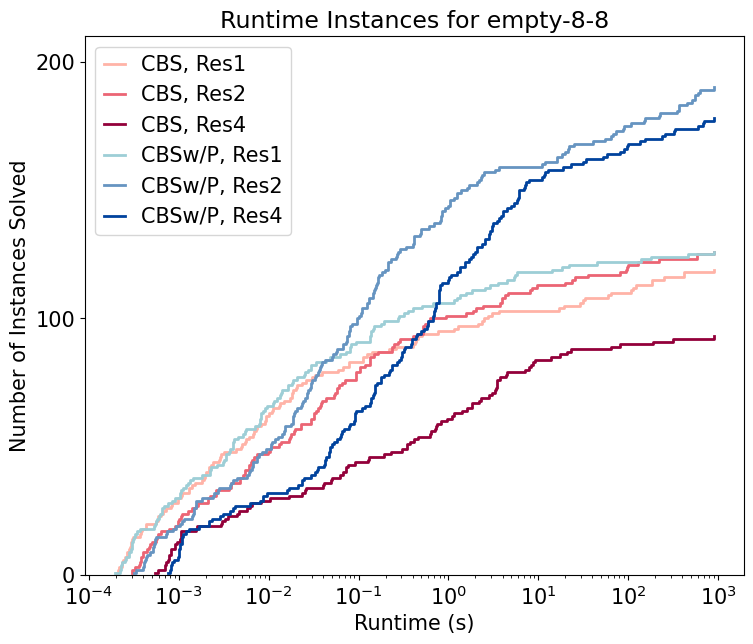

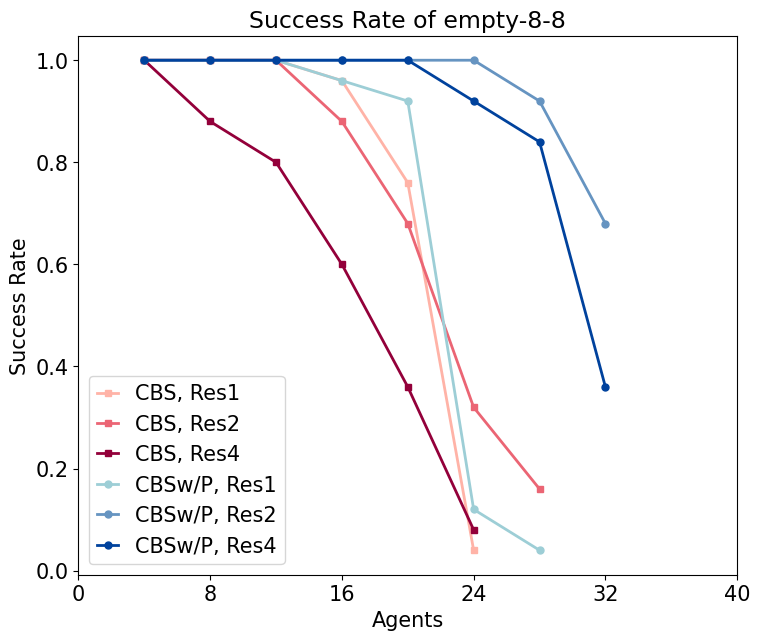

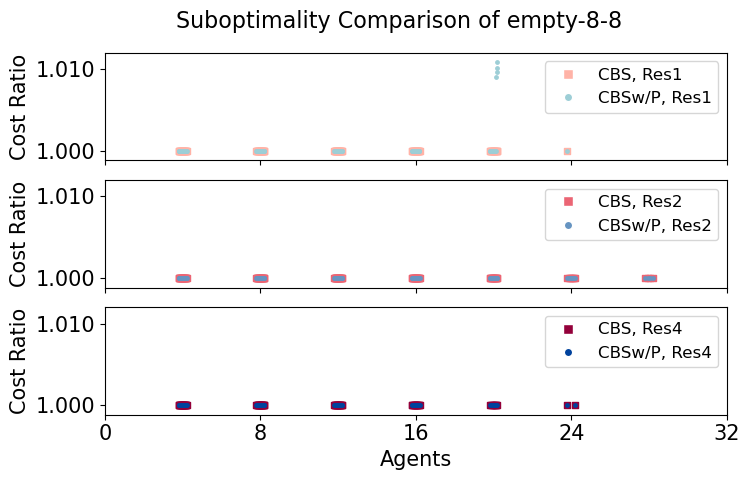

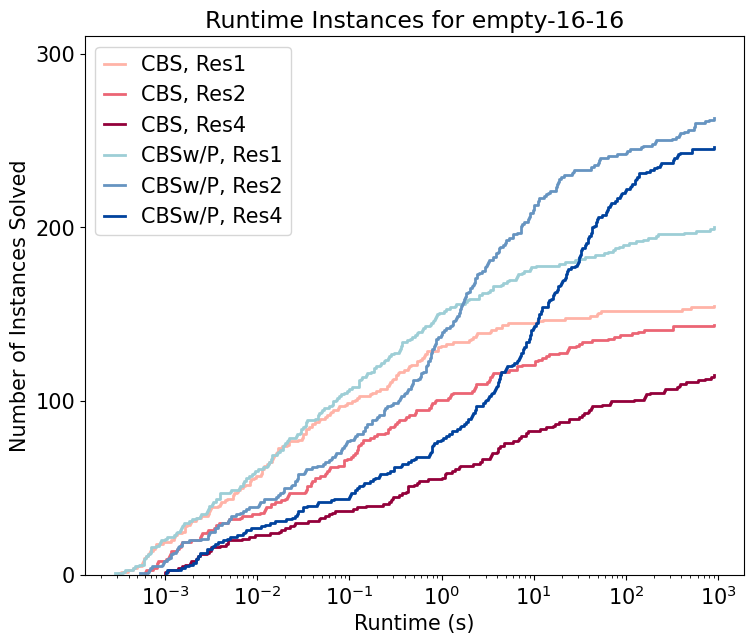

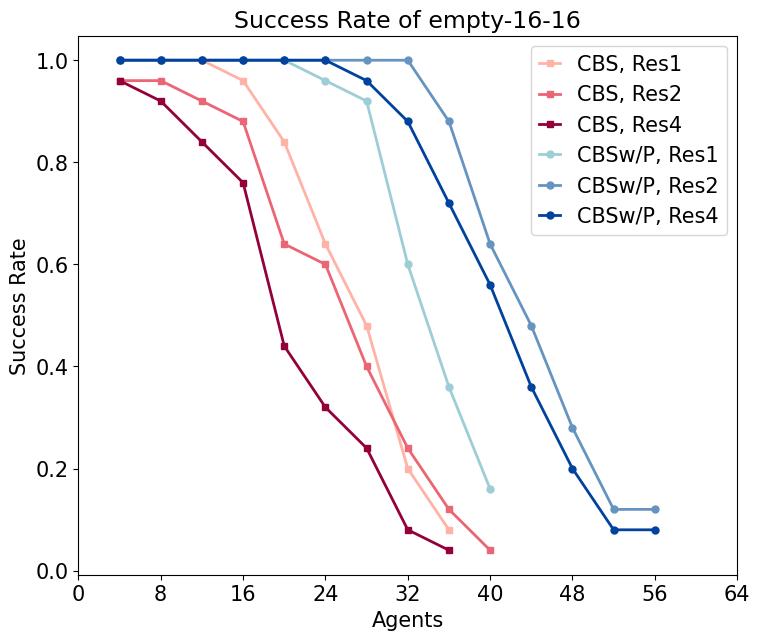

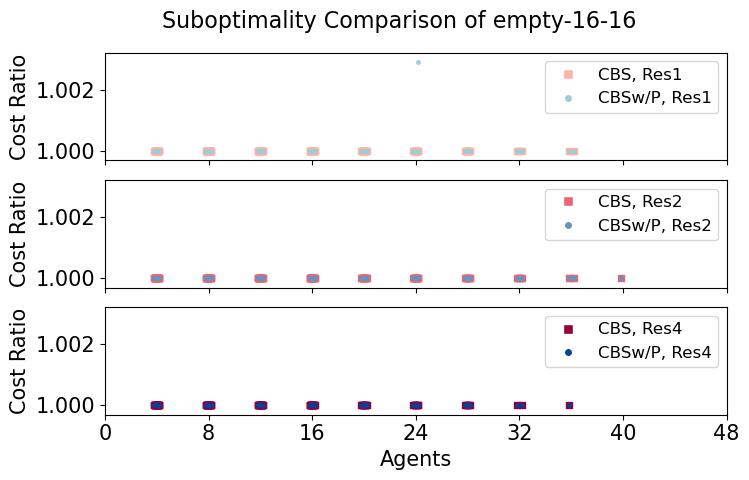

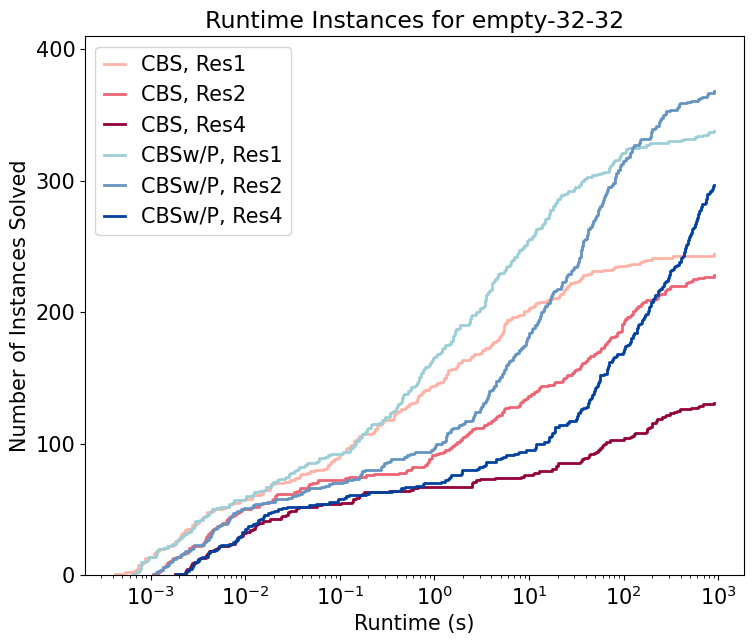

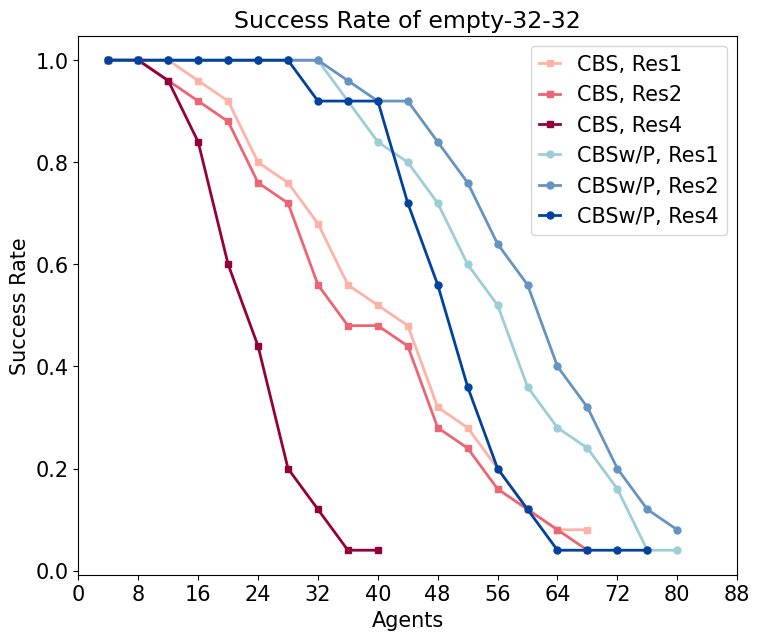

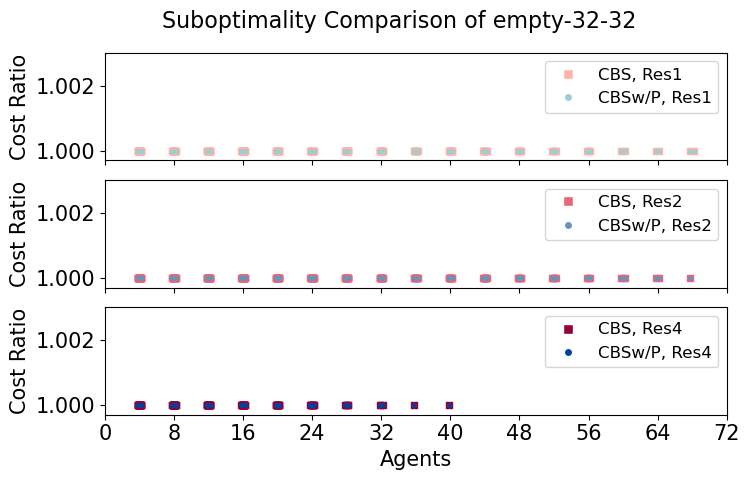

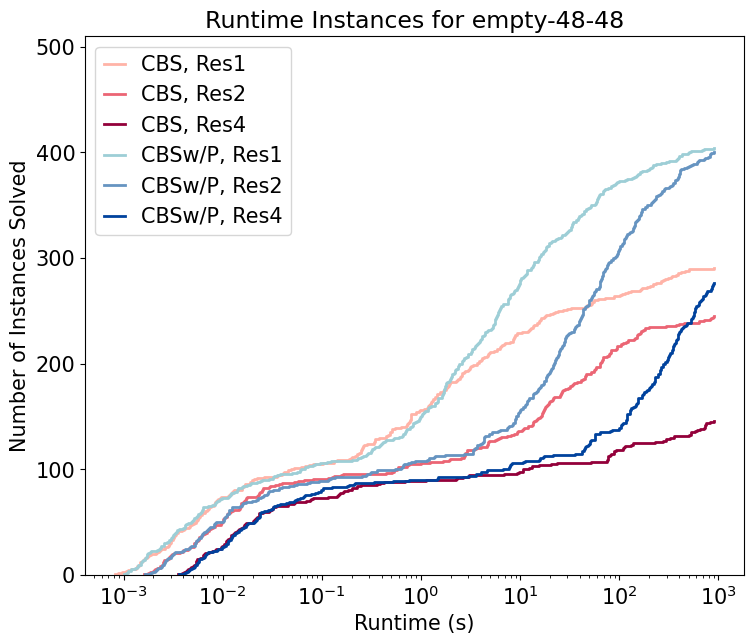

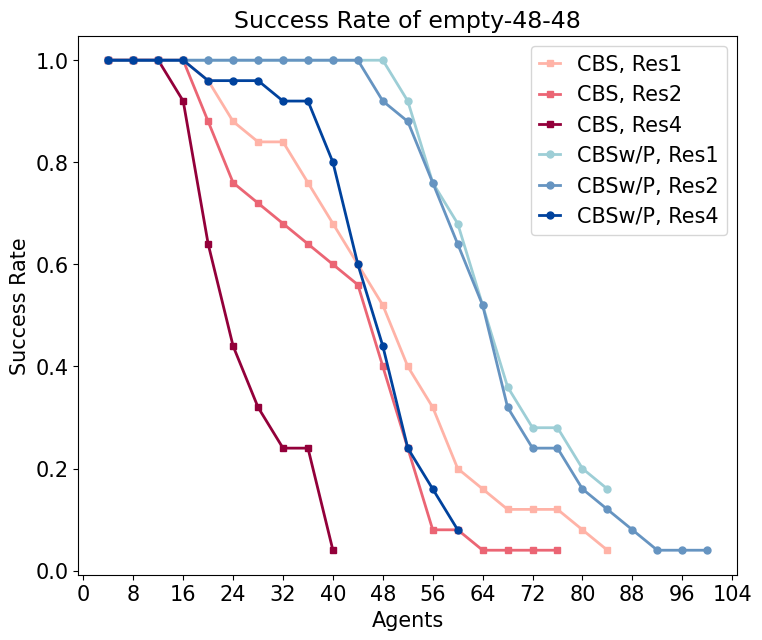

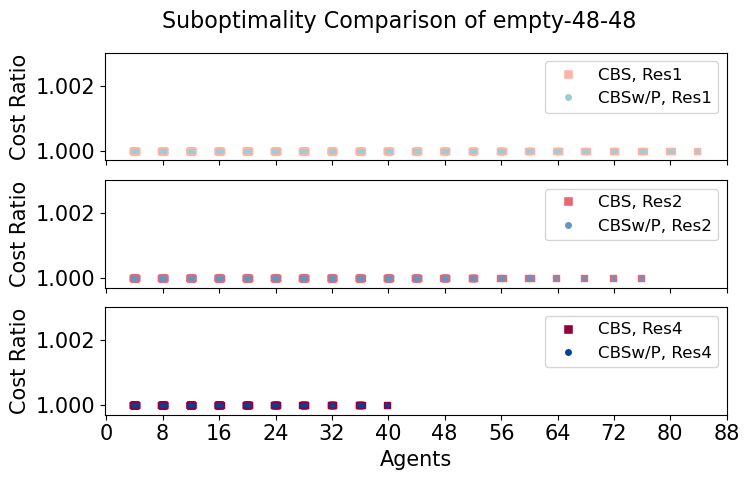

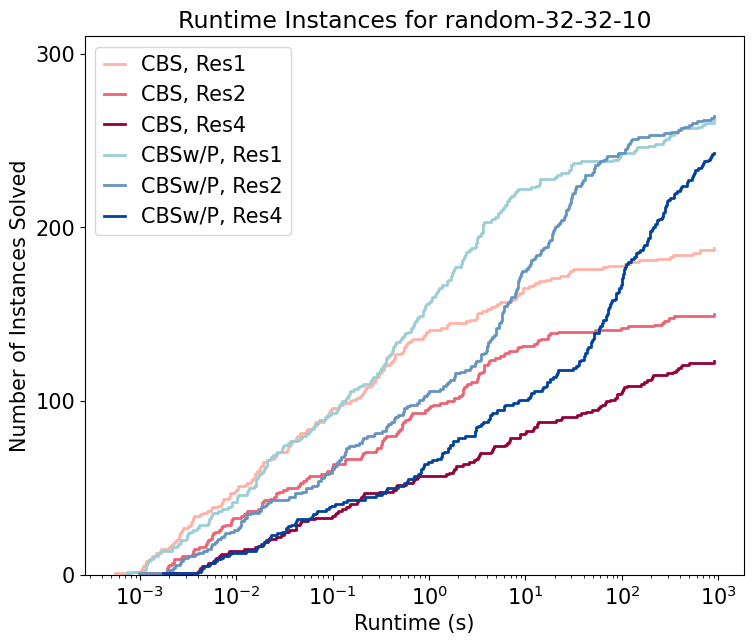

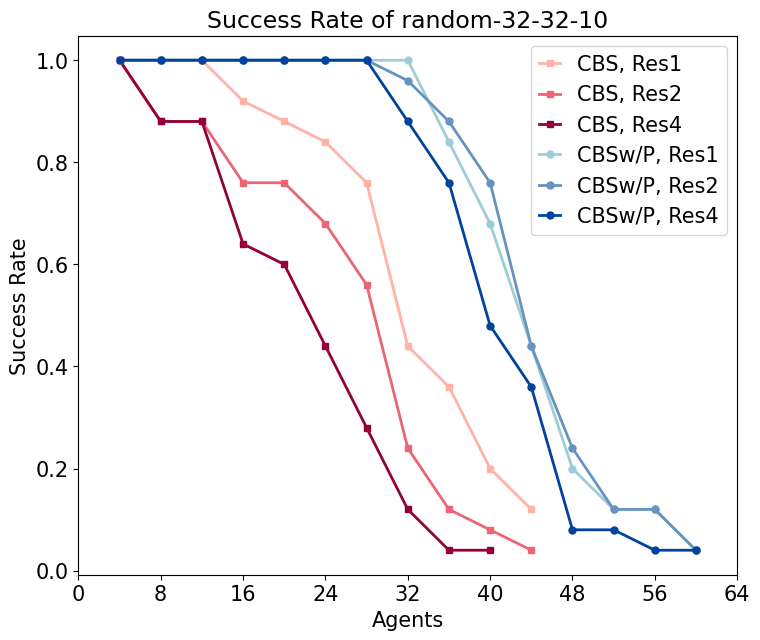

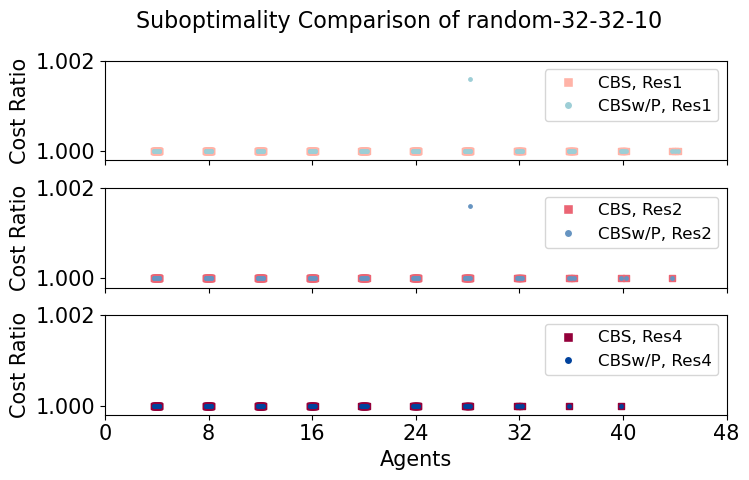

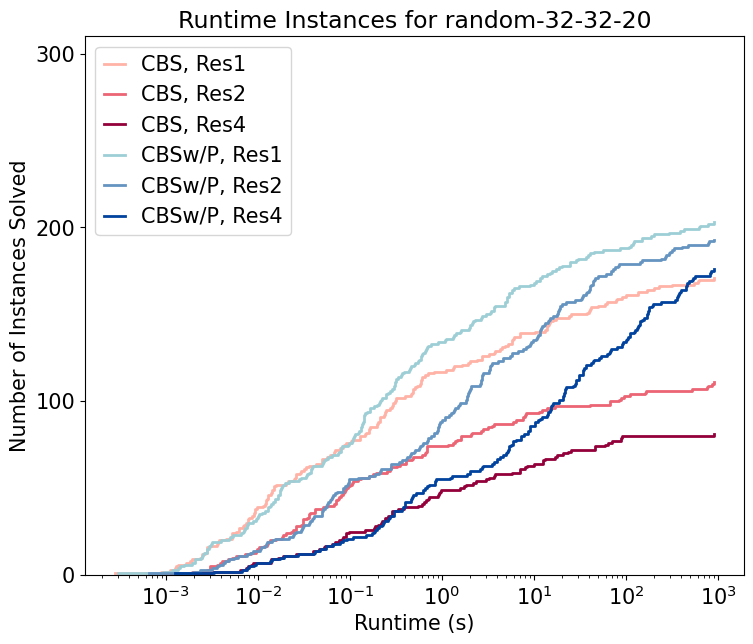

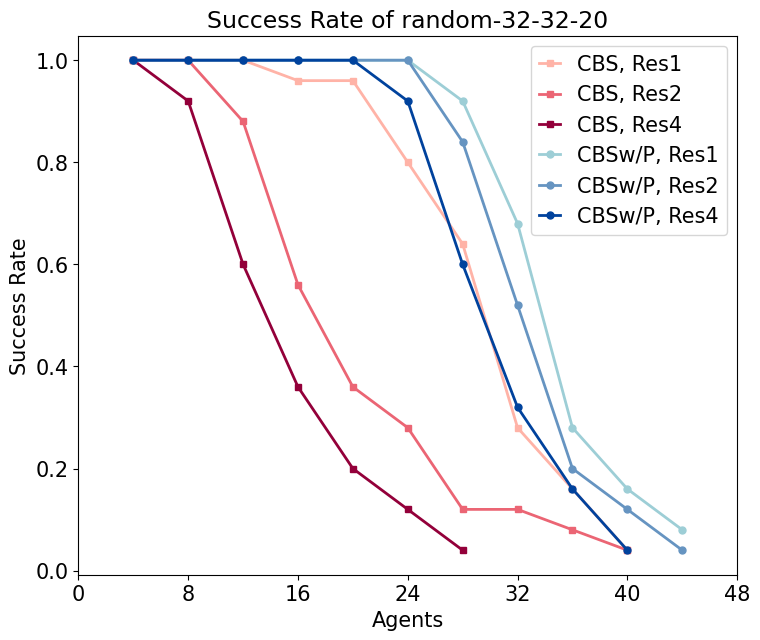

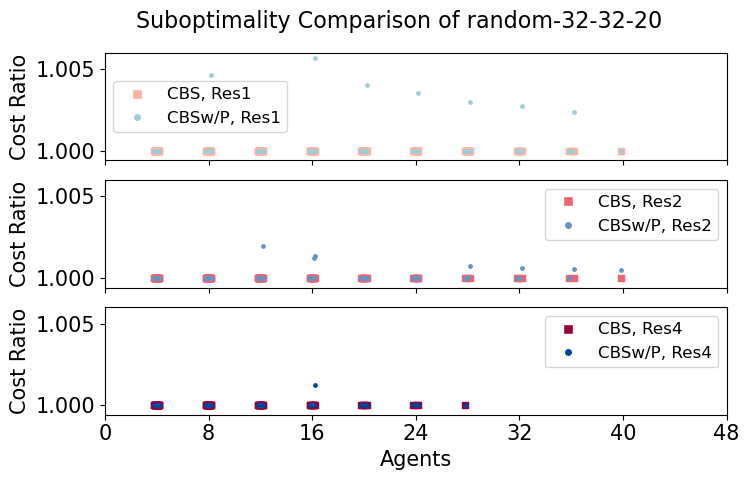

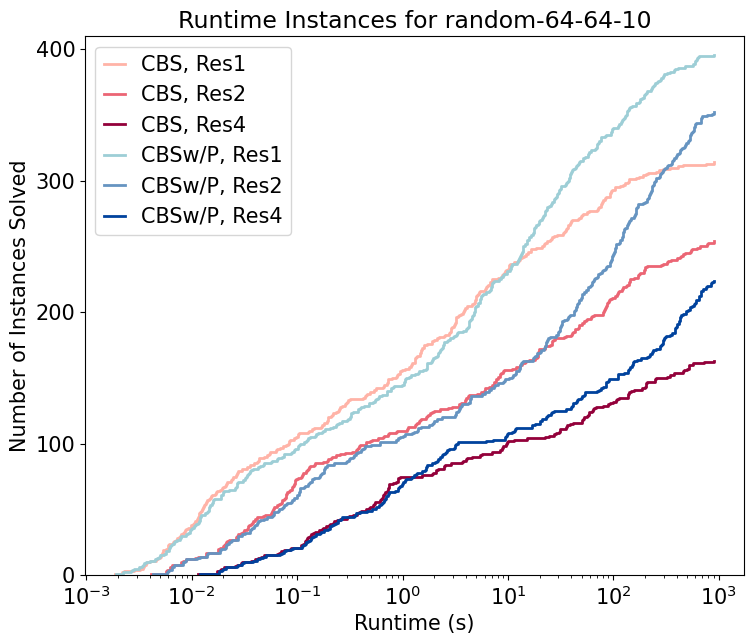

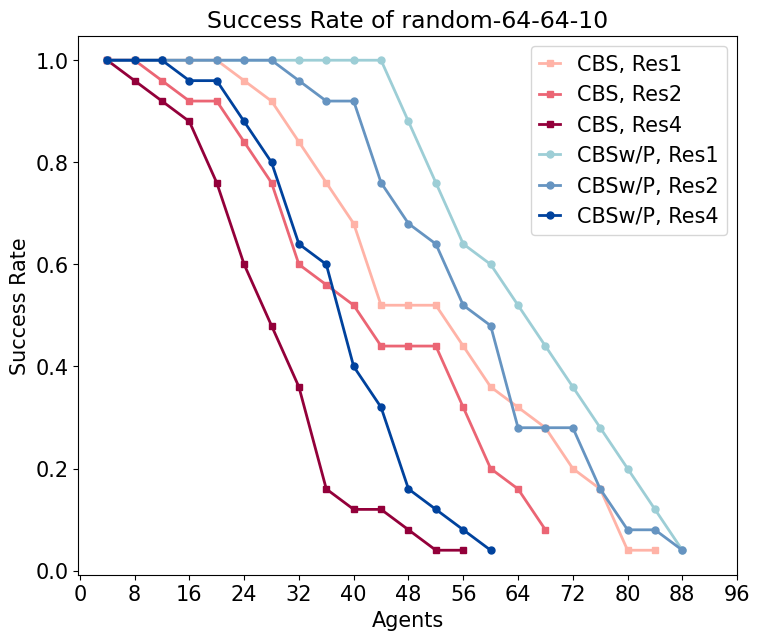

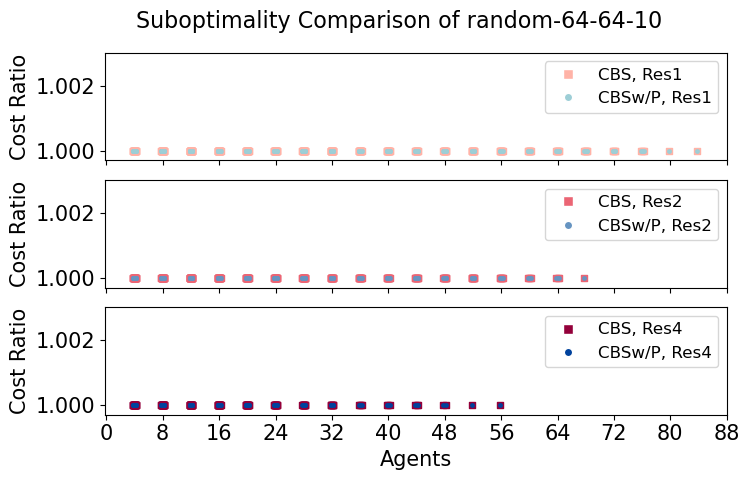

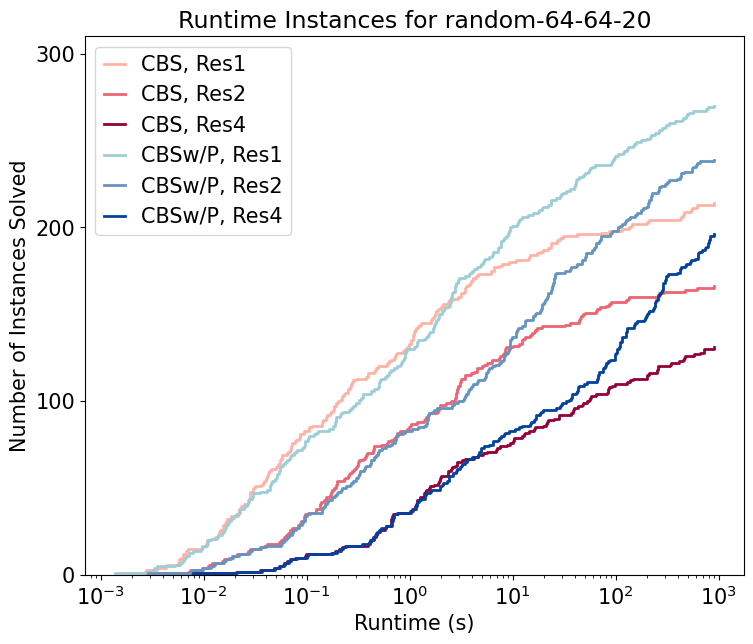

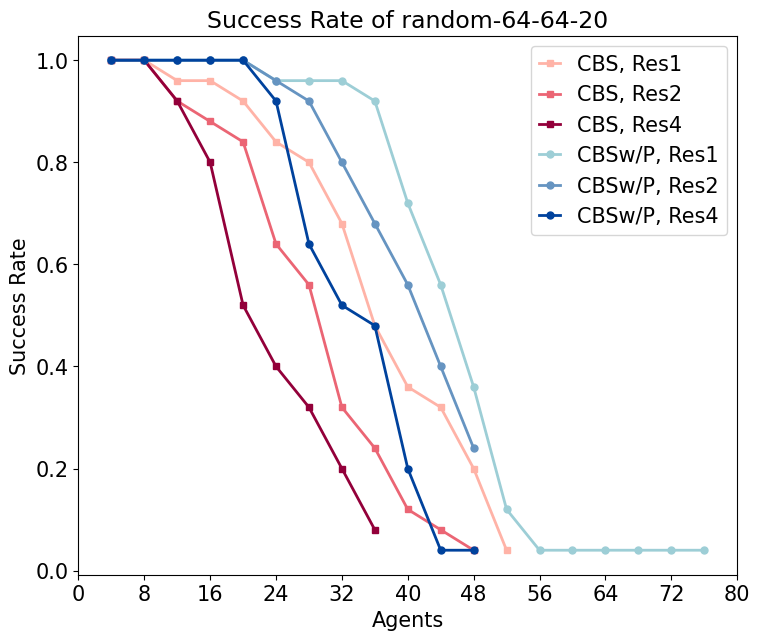

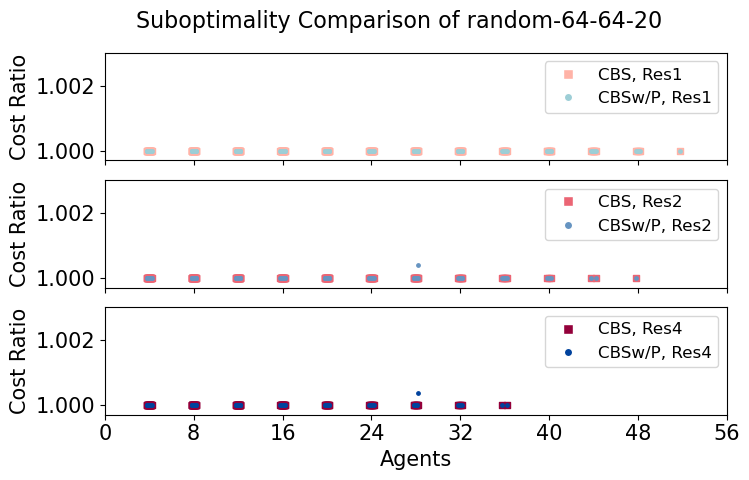

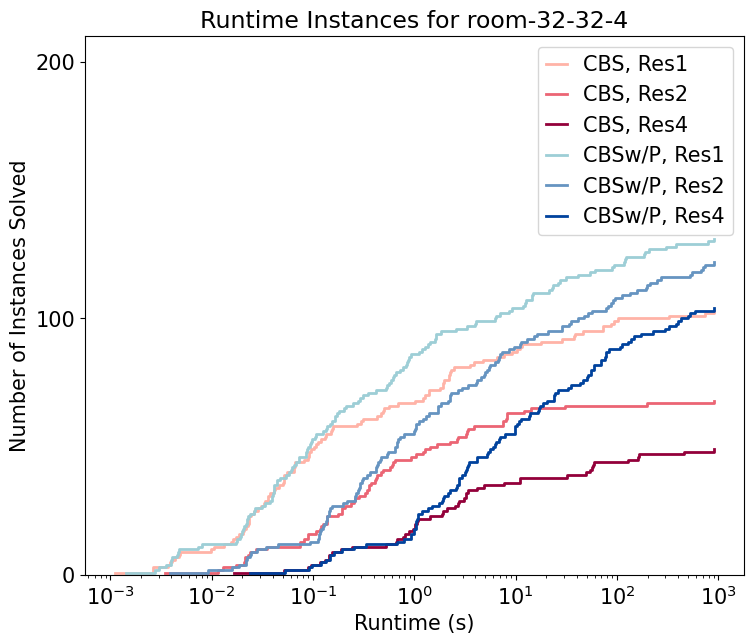

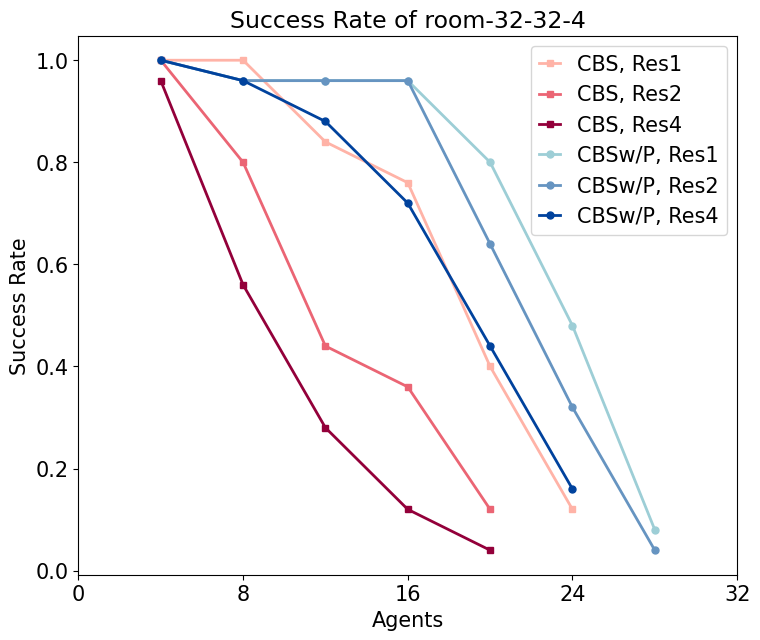

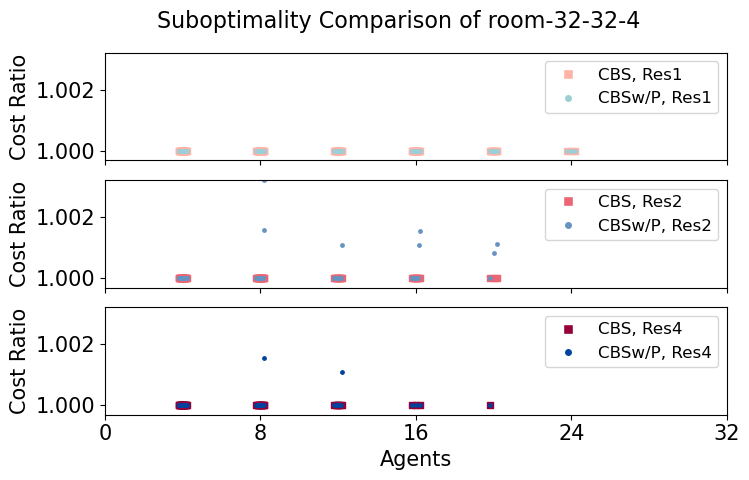

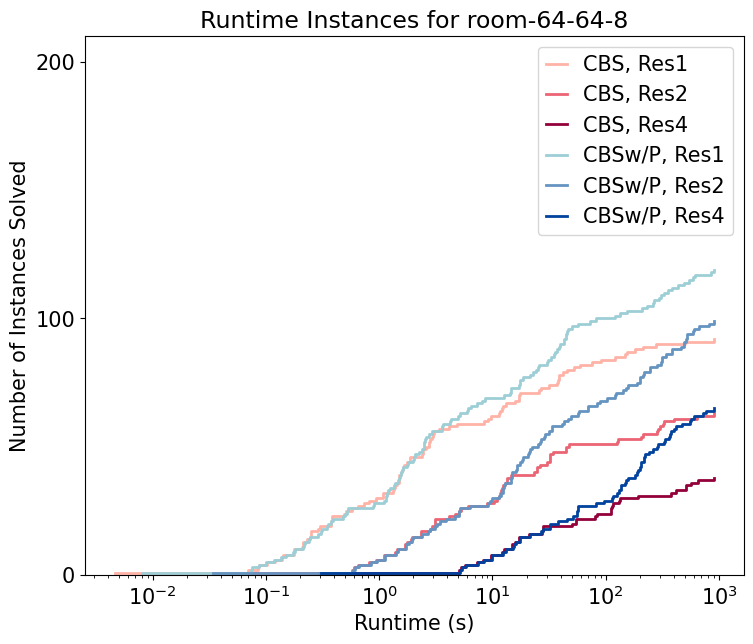

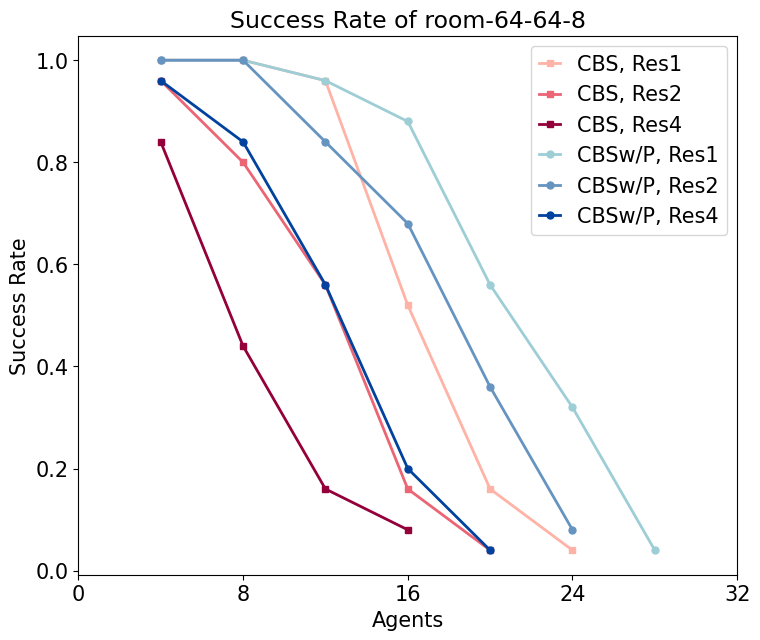

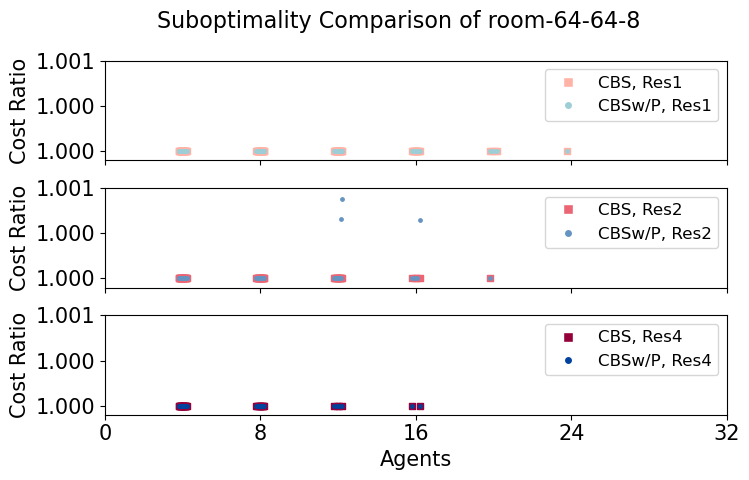

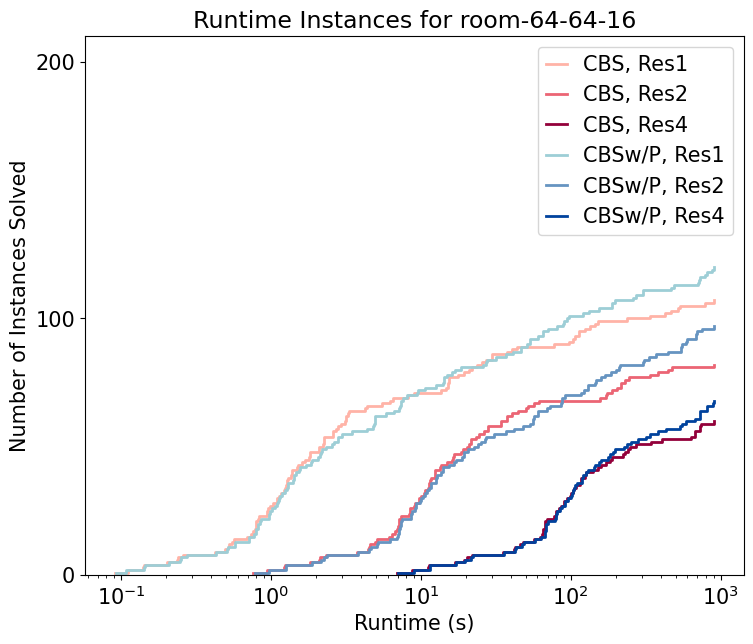

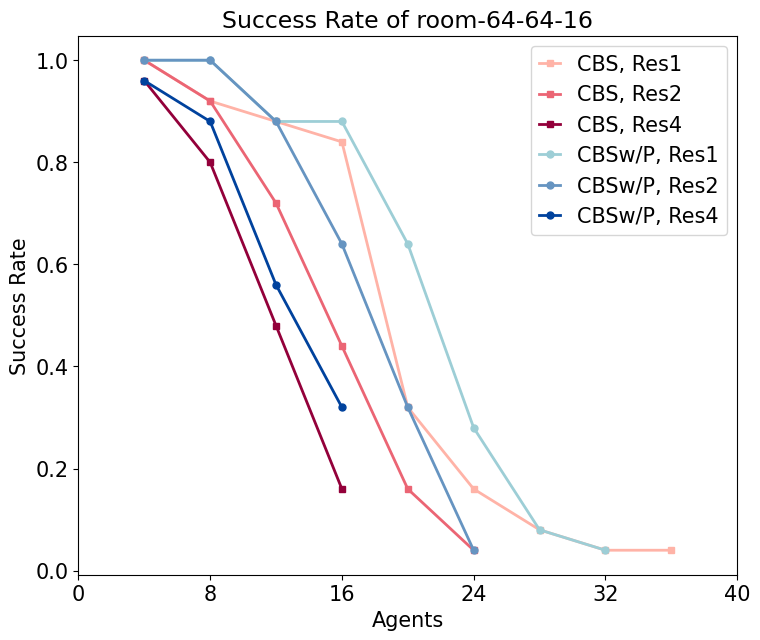

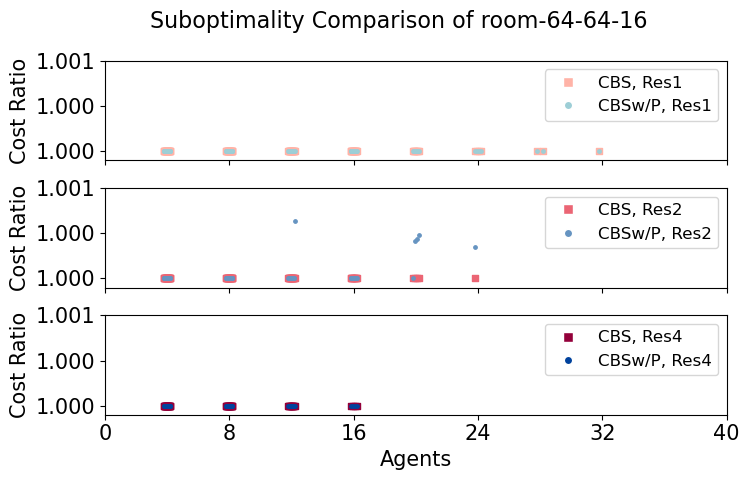

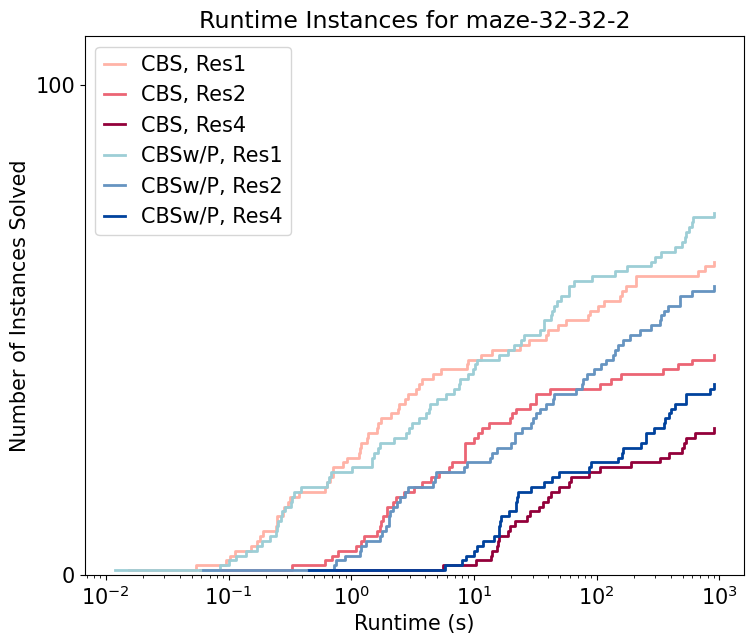

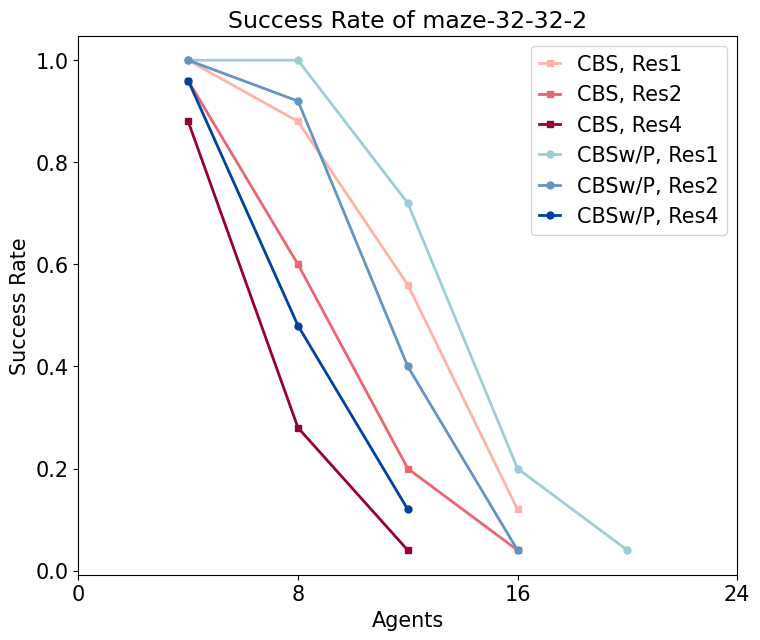

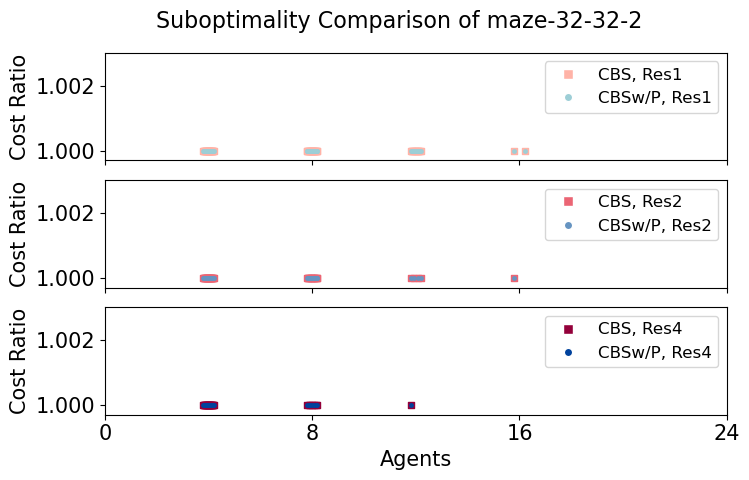

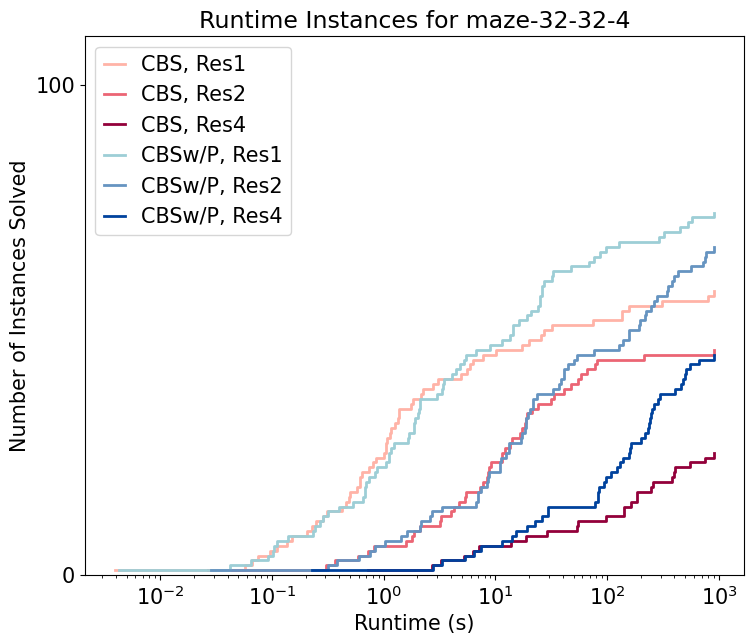

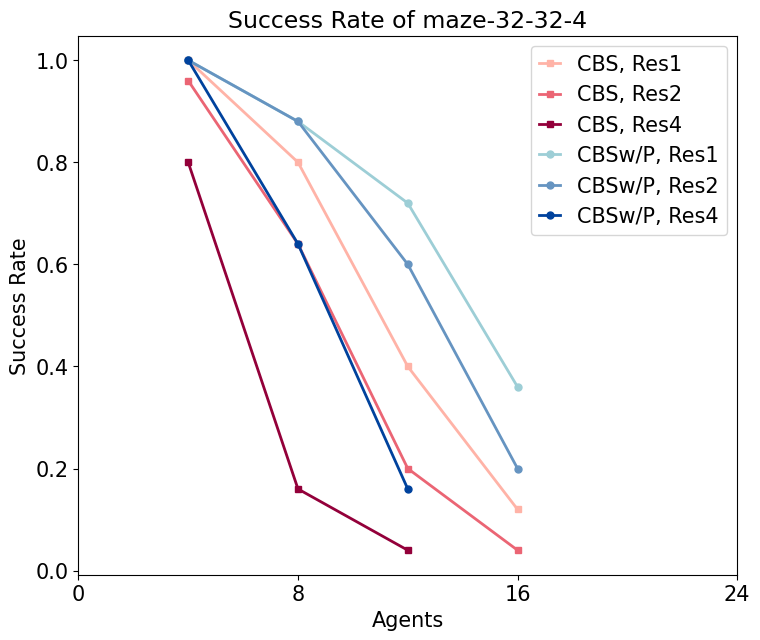

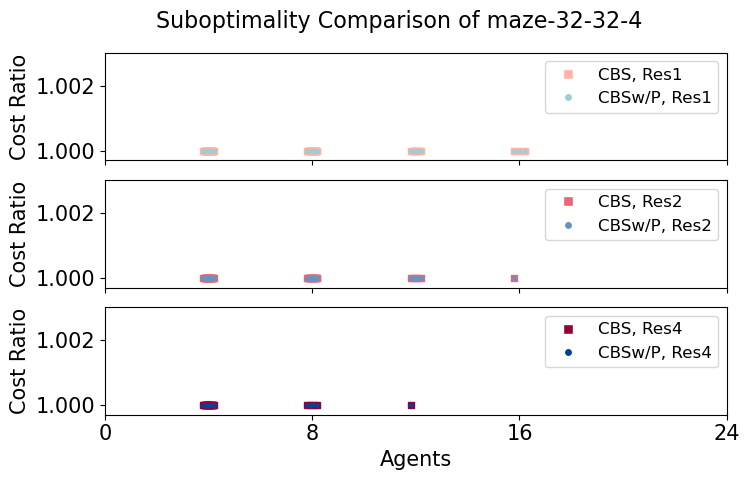

IndexError: index -1 is out of bounds for axis 0 with size 0

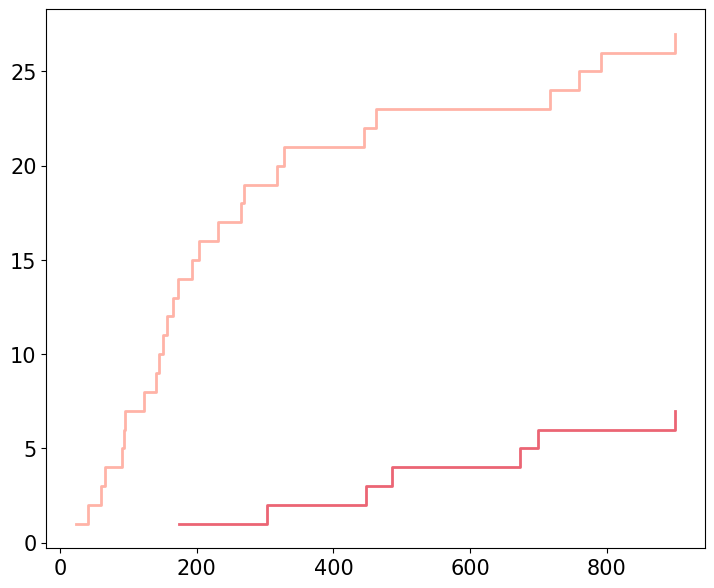

In [87]:
for map_name in map_names:
    plot_instances(map_name, individual_stats[map_name], "Figures/IndividualFigures/RuntimeInstances_" + map_name + ".png", 100)
    plot_success(map_name, individual_stats[map_name],"Figures/IndividualFigures/SuccessRate_" + map_name + ".png")
    plot_cost(map_name, individual_stats[map_name], "Figures/IndividualFigures/CostRatios_" + map_name + ".png")

In [85]:
plt.rcParams.update({
    'axes.titlesize': 17,       # Title size
    'axes.labelsize': 15,       # X and Y labels
    'xtick.labelsize': 15,      # X-axis tick labels
    'ytick.labelsize': 15,      # Y-axis tick labels
    'legend.fontsize': 15       # Legend text size
})

master_figsize=(8.5,7)

In [ ]:
up = [8, 8, 4, 8, 4]
map_groups = ["empty", "random", "narrow", "cities", "games"]
for i in range(len(map_groups)): 
    map_group = list(map_groupings.keys())[i]
    plot_instances(map_group.capitalize() + " Group", group_stats[map_group], "Figures/GroupedFigures/RuntimeInstances_" + map_group + ".png")
    plot_success(map_group.capitalize() + " Group", group_stats[map_group], "Figures/GroupedFigures/SuccessRate_" + map_group + ".png", up[i])
    plot_cost(map_group.capitalize() + " Group", group_stats[map_group], "Figures/GroupedFigures/CostRatios_" + map_group + ".png", up[i])
    

## Table Statistics

This simply prints out the minimum and maximum number of solved problem sizes for each map, algorithm, and resolution. 

In [83]:
for map_name in map_names: 
    for res in resolutions: 
        print(f"{map_name} Res {res} CBS: {individual_stats[map_name]["CBS min solved"][res]},{individual_stats[map_name]["CBS max solved"][res]}")
        print(f"{map_name} Res {res} PBS: {individual_stats[map_name]["PBS min solved"][res]},{individual_stats[map_name]["PBS max solved"][res]}")

empty-8-8 Res 1 CBS: 12,24
empty-8-8 Res 1 PBS: 12,28
empty-8-8 Res 2 CBS: 12,28
empty-8-8 Res 2 PBS: 24,32
empty-8-8 Res 4 CBS: 4,24
empty-8-8 Res 4 PBS: 20,32
empty-16-16 Res 1 CBS: 12,36
empty-16-16 Res 1 PBS: 20,40
empty-16-16 Res 2 CBS: 0,40
empty-16-16 Res 2 PBS: 32,56
empty-16-16 Res 4 CBS: 0,36
empty-16-16 Res 4 PBS: 24,56
empty-32-32 Res 1 CBS: 12,68
empty-32-32 Res 1 PBS: 32,80
empty-32-32 Res 2 CBS: 8,68
empty-32-32 Res 2 PBS: 32,80
empty-32-32 Res 4 CBS: 8,40
empty-32-32 Res 4 PBS: 28,76
empty-48-48 Res 1 CBS: 16,84
empty-48-48 Res 1 PBS: 48,84
empty-48-48 Res 2 CBS: 16,76
empty-48-48 Res 2 PBS: 44,100
empty-48-48 Res 4 CBS: 12,40
empty-48-48 Res 4 PBS: 16,60
random-32-32-10 Res 1 CBS: 12,44
random-32-32-10 Res 1 PBS: 32,60
random-32-32-10 Res 2 CBS: 4,44
random-32-32-10 Res 2 PBS: 28,60
random-32-32-10 Res 4 CBS: 4,40
random-32-32-10 Res 4 PBS: 28,60
random-32-32-20 Res 1 CBS: 12,40
random-32-32-20 Res 1 PBS: 24,44
random-32-32-20 Res 2 CBS: 8,40
random-32-32-20 Res 2 PBS: